##### Given three images of a window taken from three different viewpoints, a, b and c, I obtained the homography matrices H_ab and H_bc using the least squares method. 

1) I used numpy for matrix multiplication, transposition and inversion. 

To obtain the homography matrices using the least squares method, we have to do the following 3 steps:
- Select at least four corresponding points between each pair of images (a & b, and b & c).
- Set up a system of linear equations based on the correspondences.
- Solve the system using the least squares method to find the homography matrices.

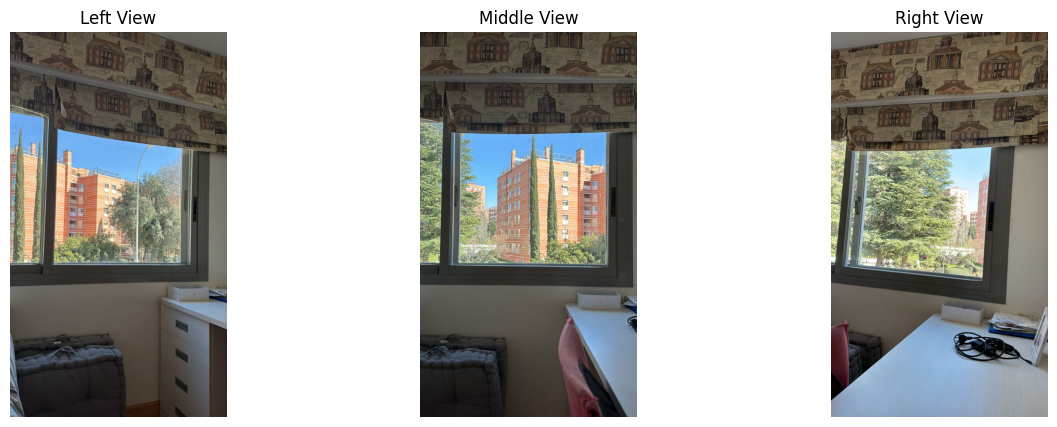

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load images
img_left_path = 'img_left.jpeg'
img_middle_path = 'img_front.jpeg'
img_right_path = 'img_right.jpeg'

img_left = cv2.imread(img_left_path)
img_middle = cv2.imread(img_middle_path)
img_right = cv2.imread(img_right_path)

# Convert images from BGR to RGB for displaying with matplotlib
img_left = cv2.cvtColor(img_left, cv2.COLOR_BGR2RGB)
img_middle = cv2.cvtColor(img_middle, cv2.COLOR_BGR2RGB)
img_right = cv2.cvtColor(img_right, cv2.COLOR_BGR2RGB)

# Display images
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(img_left)
plt.title('Left View')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(img_middle)
plt.title('Middle View')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(img_right)
plt.title('Right View')
plt.axis('off')

plt.show()

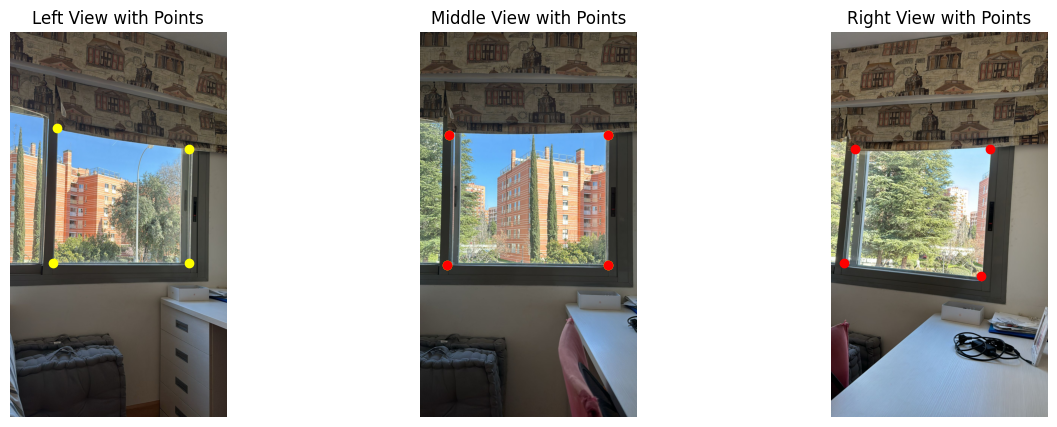

Homography matrix H_ab:
 [[ 9.49147805e-01  1.61808146e-02 -1.02216852e+02]
 [-2.61739770e-01  9.35734556e-01  1.13725474e+02]
 [-2.11080459e-04  1.61808146e-05  1.00000000e+00]]
Homography matrix H_bc:
 [[ 7.27344872e-01 -7.51116828e-02  5.89182646e+01]
 [-7.16774920e-02  8.44856543e-01  1.50382936e+02]
 [-1.15608858e-04 -1.45042974e-05  1.00000000e+00]]


In [2]:
# Next, we manually select points for the homography between the left and middle images
# Format: (x_left, y_left, x_middle, y_middle)
points_ab = np.array([
    # Points from the left image matched with points from the middle image
    [230, 1230, 140, 1240],  # This points are made to fit the edges of the windows
    [250, 510, 150, 550],  
    [950, 620, 1000, 550],  
    [950, 1230, 1000, 1240], 
], dtype='float32')

# Similarly, manually selected points for the homography between the middle and right images
# Format: (x_middle, y_middle, x_right, y_right)
points_bc = np.array([
    # Points from the middle image matched with points from the right image
    [140, 1240, 70, 1230],  # Example point 1
    [150, 550, 130, 620],  # Example point 2
    [1000, 550, 850, 620],  # Example point 3
    [1000, 1240, 800, 1300],  # Example point 4
], dtype='float32')

# Splitting points into separate lists for each image pair
points_a = points_ab[:, :2]
points_b_ab = points_ab[:, 2:]

points_b_bc = points_bc[:, :2]
points_c = points_bc[:, 2:]

# Display points on the images
plt.figure(figsize=(15, 5))

# Left image with points
plt.subplot(1, 3, 1)
plt.imshow(img_left)
plt.scatter(points_a[:, 0], points_a[:, 1], c='yellow')
plt.title('Left View with Points')
plt.axis('off')

# Middle image with points
plt.subplot(1, 3, 2)
plt.imshow(img_middle)
plt.scatter(points_b_ab[:, 0], points_b_ab[:, 1], c='yellow')
plt.scatter(points_b_bc[:, 0], points_b_bc[:, 1], c='red')
plt.title('Middle View with Points')
plt.axis('off')

# Right image with points
plt.subplot(1, 3, 3)
plt.imshow(img_right)
plt.scatter(points_c[:, 0], points_c[:, 1], c='red')
plt.title('Right View with Points')
plt.axis('off')

plt.show()


# Function to compute homography using least squares
def compute_homography_least_squares(points):
    # Determine the number of point correspondences
    num_points = points.shape[0]
     # We initialize matrix A (2*num_points x 8) for linear equations and vector b (2*num_points x 1) for solutions
    A = np.zeros((2 * num_points, 8))
    b = np.zeros((2 * num_points, 1))
    
    for i, (x1, y1, x2, y2) in enumerate(points):
        # For each point, we create two rows in A and two entries in b
        # First row for the x-coordinate
        A[2*i] = [x1, y1, 1, 0, 0, 0, -x2*x1, -x2*y1]
        A[2*i + 1] = [0, 0, 0, x1, y1, 1, -y2*x1, -y2*y1]
        b[2*i] = x2
        b[2*i + 1] = y2
    
    # Solve using least squares: h = (A^T A)^-1 A^T b
    A_transpose = A.T
    h = np.dot(np.linalg.inv(np.dot(A_transpose, A)), np.dot(A_transpose, b))
    h = np.append(h, 1)  # Append 1 for the last element to reshape into 3x3 matrix
    
    return h.reshape((3, 3))

# Compute homography matrices
H_ab = compute_homography_least_squares(points_ab)
H_bc = compute_homography_least_squares(points_bc)

print("Homography matrix H_ab:\n", H_ab)
print("Homography matrix H_bc:\n", H_bc)

Next, we compute a view equivalent to c, using only image a and the homographies previously computed:

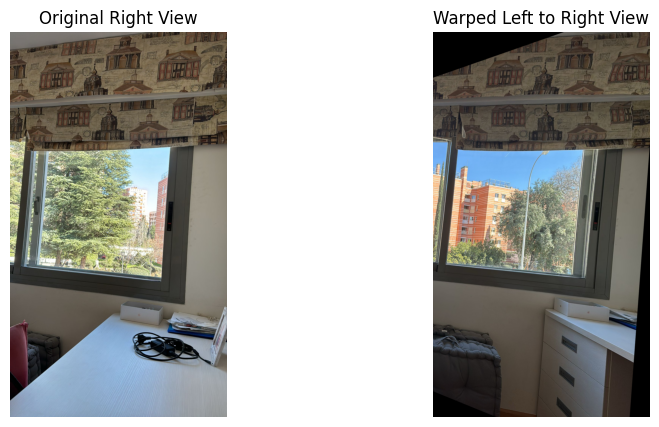

In [3]:
def warp_two_step(img, H1, H2, output_shape):
    """
    Now we apply two homography transformations in sequence to an image and warp it to the output shape.
    :param img: The original image to transform.
    :param H1: The first homography matrix.
    :param H2: The second homography matrix.
    :param output_shape: The shape (height, width) of the output image.
    :return: The warped image.
    """
    # Concatenate the two homographies
    H = np.dot(H2, H1)

    # Warp the image using the concatenated homography
    warped_img = cv2.warpPerspective(img, H, output_shape)

    return warped_img

# Assuming the shape of the right image is the desired output shape
output_shape = (img_right.shape[1], img_right.shape[0])

# Warp the left image to the right view using the two homographies
img_a_to_c = warp_two_step(img_left, H_ab, H_bc, output_shape)

# Display the original right image and the warped left image
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img_right)
plt.title('Original Right View')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_a_to_c)
plt.title('Warped Left to Right View')
plt.axis('off')

plt.show()
